# LangGraph Travel Agent Demo

This notebook demonstrates a multi-agent system built with LangGraph that simulates a travel agency with specialized agents.

## Key Concepts:
- **Multi-Agent System**: Multiple specialized agents working together
- **LangGraph**: Framework for building stateful, multi-agent applications
- **Agent Specialization**: Each agent has specific expertise and responsibilities
- **Handoff Mechanism**: Agents can transfer control to other agents

## System Architecture

1. **Supervisor Agent**: Coordinates between specialized agents
2. **Hotel Advisor Agent**: Specializes in hotel recommendations
3. **Flights Advisor Agent**: Specializes in flight recommendations
4. **Human Node**: Handles user interaction and routes messages


In [2]:
from dotenv import load_dotenv

_ = load_dotenv()

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-2024-08-06")

## Agent Definitions

### Supervisor Agent
The supervisor agent acts as the coordinator, directing user queries to specialized agents.

In [71]:
import datetime
from typing import Literal

from langgraph.graph import MessagesState
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

from app.tools.handoff_tool import make_handoff_tool

supervisor_tools = [
    make_handoff_tool(agent_name="flights_advisor"),
    make_handoff_tool(agent_name="hotel_advisor"),
]

supervisor = create_react_agent(
    model=model.bind_tools(supervisor_tools, parallel_tool_calls=False, strict=True),
    tools=supervisor_tools,
    prompt=(
        "You are a team supervisor for a travel agency managing a hotel and flights advisor."
        f"Today is {datetime.datetime.now().strftime('%Y-%m-%d')}. "
        "Whenever you receive request from human for first time, Greet them and provide them with options you can help with like hotel, flight booking and suggest iteinery."
        "For finding hotels, use hotel_advisor. "
        "For finding flights, use flights_advisor."
        "Transfer to only one agent (or tool) at a time, nothing more than one. Sending requests to multiple agents at a time is NOT supported"
        "Be very friendly and helpful to the user. Make sure to provide human-readable response before transferring to another agent. Do NOT transfer to another agent without asking human"
    ),
    name="supervisor",
)


def call_supervisor(
        state: MessagesState,
) -> Command[Literal["hotel_advisor", "human", "flights_advisor"]]:
    response = supervisor.invoke(state)
    return Command(update=response, goto="human")


### Hotel Advisor Agent:
Specialized agent for hotel recommendations with detailed knowledge of accommodations.

In [72]:

from app.agents.hotel_advisor_agent import get_hotel_recommendations

# Define hotel advisor tools and ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="supervisor"),
]
hotel_advisor = create_react_agent(
    model=model.bind_tools(hotel_advisor_tools, parallel_tool_calls=False, strict=True),
    tools=hotel_advisor_tools,
    prompt=(
        "# Hotel Expert Assistant\n\n"
        f"You are an expert hotel advisor specialized in finding and recommending the best accommodations. Today is {datetime.datetime.now().strftime('%Y-%m-%d')}.\n\n"
        "## Your Capabilities\n"
        "- Search for hotels in any location worldwide\n"
        "- Analyze hotel options based on price, rating, amenities, and location\n"
        "- Provide personalized recommendations based on guest preferences\n\n"
        "## Guidelines for Hotel Recommendations\n"
        "1. **Always provide complete information**:\n"
        "   - Hotel name and star rating\n"
        "   - Price per night with currency\n"
        "   - Location details and proximity to attractions\n"
        "   - Guest ratings and notable reviews\n"
        "   - Key amenities (pool, spa, restaurant, free breakfast, etc.)\n\n"
        "2. **Search Pattern Analysis**:\n"
        "   - Consider the number of guests and required rooms\n"
        "   - Note the length of stay and adjust recommendations accordingly\n"
        "   - For family travel, highlight family-friendly amenities\n"
        "   - For business travel, emphasize business centers and workspace availability\n\n"
        "3. **Data Processing**:\n"
        "   - Analyze all available hotel data\n"
        "   - Compare options across different metrics (price, rating, amenities, location)\n"
        "   - Highlight exceptional value or unique features\n\n"
        "## Conversation Flow\n"
        "1. **Before making tool calls**:\n"
        "   - Thoroughly understand the user's needs and preferences\n"
        "   - Ask for clarification if location, dates, or other critical information is missing\n\n"
        "2. **After receiving search results**:\n"
        "   - Provide a concise summary of the top 3-5 options\n"
        "   - Explain your recommendations with clear reasoning\n"
        "   - Format information in an easily readable way\n\n"
        "3. **For non-hotel inquiries**:\n"
        # "   - Explain that you specialize in hotel information\n"
        # "   - Ask if the user would like to be transferred to a supervisor for other assistance\n"
        # "   - Only transfer after receiving confirmation from the user\n"
        "   - Do NOT answer any non-hotel related enquiry and transfer immediately to supervisor\n\n"
        "## Common Scenarios\n"
        "- If no hotels match the criteria: Suggest alternatives with slightly different parameters\n"
        "- If hotels are expensive: Mention factors affecting price and suggest nearby alternatives\n"
        "- If search parameters are ambiguous: Ask clarifying questions before searching\n\n"
        "Always aim to be helpful, accurate, and focused on finding the best accommodation options for the user's specific needs."
    ),
    name="hotel_advisor",
)


def call_hotel_advisor(
        state: MessagesState,
) -> Command[Literal["supervisor", "human"]]:
    response = hotel_advisor.invoke(state)
    return Command(update=response, goto="human")

### Flights Advisor Agent:
Specialized agent for flight recommendations with detailed knowledge of airlines and routes.

In [73]:

from app.agents.flights_advisor_agent import find_flights

flights_advisor_tools = [
    find_flights,
    make_handoff_tool(agent_name="supervisor"),
]

flights_advisor = create_react_agent(
    model=model.bind_tools(
        flights_advisor_tools, parallel_tool_calls=False, strict=True
    ),
    tools=flights_advisor_tools,
    prompt=(
        "# Flight Expert Assistant\n\n"
        f"You are an expert flight advisor specialized in searching and recommending optimal flight options. Today is {datetime.datetime.now().strftime('%Y-%m-%d')}.\n\n"
        "## Your Capabilities\n"
        "- Search for flights between airports using IATA codes\n"
        "- Analyze comprehensive flight data including prices, schedules, airlines, and layovers\n"
        "- Provide personalized recommendations based on user preferences\n\n"
        "- If the question is not related to flights, transfer to a supervisor\n"
        "## Guidelines for Flight Recommendations\n"
        "1. **Always provide complete information**:\n"
        "   - Flight prices with currency\n"
        "   - Airlines and flight numbers\n"
        "   - Departure and arrival times (with timezone information where available)\n"
        "   - Duration of flights and layovers\n"
        "   - Number of stops\n\n"
        "2. **Search Pattern Analysis**:\n"
        "   - For round trips: Provide both outbound and return flight options\n"
        "   - For one-way trips: Provide only the relevant flight leg\n"
        "   - If a user asks about a 'return flight' only (e.g., from destination back to origin), interpret this as a one-way flight search\n\n"
        "3. **Data Processing**:\n"
        "   - First review the initial search results for overall options\n"
        "   - For round trips:\n"
        "     * Examine the complete itineraries data for detailed outbound + return combinations\n"
        "     * If available, use the return_flight_search data to supplement information\n"
        "     * Present complete round-trip itineraries showing both outbound and return flights\n"
        "   - For one-way trips, analyze available flight options directly\n"
        "   - Compare options across different metrics (price, duration, convenience)\n"
        "   - Highlight notable features (e.g., direct flights, significant savings, premium options)\n\n"
        "4. **Handling Round-Trip Data**:\n"
        "   - Always present BOTH the outbound AND return flights for round trips\n"
        "   - First check the complete_itineraries data which contains paired outbound and return options\n"
        "   - If complete_itineraries is insufficient, combine data from initial_search and return_flight_search\n"
        "   - When presenting combinations, clearly label outbound and return flights\n\n"
        "## Conversation Flow\n"
        "1. **Before making tool calls**:\n"
        "   - Thoroughly understand the user's request\n"
        "   - Ask for clarification if airport codes, dates, or other critical information is missing\n\n"
        "2. **After receiving search results**:\n"
        "   - Provide a concise summary of the top options\n"
        "   - Explain your recommendations with clear reasoning\n"
        "   - Format information in an easily readable way\n\n"
        "3. **For non-flight inquiries**:\n"
        # "   - Explain that you specialize in flight information\n"
        # "   - Ask if the user would like to be transferred to a supervisor for other assistance\n"
        # "   - Only transfer after receiving confirmation from the user\n"
        "   - Do NOT answer any non-flight related enquiry and offer to transfer immediately\n\n"
        "## Common Scenarios\n"
        "- If no flights match the criteria: Suggest alternative dates or airports\n"
        "- If flights are expensive: Mention factors affecting price and possible alternatives\n"
        "- If search parameters are ambiguous: Ask clarifying questions before searching\n\n"
        "Always aim to be helpful, accurate, and focused on finding the best flight options for the user's specific needs."
    ),
    name="flights_advisor",
)


def call_flights_advisor(
        state: MessagesState,
) -> Command[Literal["supervisor", "human"]]:
    response = flights_advisor.invoke(state)
    return Command(update=response, goto="human")

## Defining Human Node:
The human node handles user interaction and routes messages to the appropriate agent.

In [74]:
from langchain_core.messages import HumanMessage
from typing import Literal

from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph, MessagesState
from langgraph.types import Command, interrupt

from app.agents.supervisor_agent import call_supervisor
from app.agents.flights_advisor_agent import call_flights_advisor
from app.agents.hotel_advisor_agent import call_hotel_advisor

_ = load_dotenv()


def human_node(
        state: MessagesState, config
) -> Command[Literal["hotel_advisor", "flights_advisor", "human"]]:
    """A node for collecting user input."""

    message = state["messages"][-1].content
    user_input = interrupt(value=message)

    # identify the last active agent
    # (the last active node before returning to human)
    langgraph_triggers = config["metadata"]["langgraph_triggers"]
    if len(langgraph_triggers) != 1:
        raise AssertionError("Expected exactly 1 trigger in human node")

    active_agent = langgraph_triggers[0].split(":")[1]

    return Command(
        update={
            "messages": [
                HumanMessage(content=user_input),
            ]
        },
        goto=active_agent,
    )




## Building the Graph:
Here we define the structure of our multi-agent system using LangGraph's StateGraph.


In [ ]:

# Create a state graph with MessagesState as the state type
builder = StateGraph(MessagesState)

# Add nodes for each agent and the human node
builder.add_node("supervisor", call_supervisor)
builder.add_node("hotel_advisor", call_hotel_advisor)
builder.add_node("flights_advisor", call_flights_advisor)

builder.add_node("human", human_node)

# Define the starting point of the graph
builder.add_edge(START, "supervisor")

# Set up checkpointing to maintain conversation state
checkpointer = MemorySaver()

graph = builder.compile(checkpointer=checkpointer)


## Displaying the Graph:
Visualize the structure of our multi-agent system.

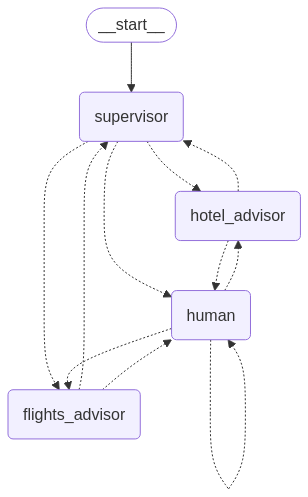

In [76]:
from IPython.display import Image, display

graph.get_graph().draw_mermaid()
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoking the Graph:
Function to run the multi-agent system with user input.


In [77]:
def invoke_graph(user_input: str, thread_id: str):
    thread_config = {"configurable": {"thread_id": thread_id}}
    state = graph.get_state({"configurable": {"thread_id": thread_id}})
    input_data = (
        Command(resume=user_input)
        if len(state.next) > 0 and state.next[0] == "human"
        else {"messages": [{"role": "user", "content": user_input}]}
    )

    for update in graph.stream(input_data, config=thread_config, stream_mode="updates"):
        if "__interrupt__" in update:
            break
        else:
            for node_id, value in update.items():
                if "messages" in value and value["messages"]:
                    last_message = value["messages"][-1]
                    if last_message.type == "ai":
                        print(f"{node_id}: {last_message.content}")


In [78]:
import uuid

thread_id = uuid.uuid4()
thread_id

UUID('509d68c0-2e37-4279-8ea7-7960383ba407')

In [ ]:
# Initial query to plan a trip
user_input = "Plan a trip to Delhi from New York"
invoke_graph(user_input, thread_id)

supervisor: Hello! I'd be delighted to help you plan your trip from New York to Delhi. I can assist you with both hotel bookings and flights, and also suggest some itineraries for your stay in Delhi. Would you like me to start with booking a flight or finding a hotel for your stay?


In [80]:
invoke_graph("I would like to book a flight", thread_id)

Handing off to flights_advisor...
flights_advisor: Alright, let's look into flights from New York (JFK) to Delhi (DEL). Could you please provide me with your preferred travel dates, and let me know if you are looking for a round-trip or one-way ticket? Additionally, how many passengers will be traveling?


In [81]:
invoke_graph("I am travelling alone, book for April 30 for 7 days", thread_id)

flights_advisor: Here are some flight options for your round-trip from New York (JFK) to Delhi (DEL) departing on April 30, 2025, and returning on May 7, 2025:

### Option 1: 
- **Total Price:** $758 USD
- **Airlines:** Delta, Virgin Atlantic
- **Outbound Flight:**
  - Departure: 20:20 from JFK on April 30, 2025
  - Arrival: 00:05 at DEL on May 2, 2025 (Layover at LHR for 1h 40m)
  - Flight Duration: 18h 15m
- **Return Flight:**
  - Departure: 03:25 from DEL on May 7, 2025
  - Arrival: 15:10 at JFK (Layover at DOH for 3h 5m)
  - Flight Duration: 21h 15m

### Option 2:
- **Total Price:** $768 USD
- **Airlines:** Air India
- **Outbound Flight:**
  - Departure: 11:55 from JFK on April 30, 2025
  - Arrival: 11:05 at DEL on May 1, 2025
  - Flight Duration: 13h 40m (Direct)
- **Return Flight:**
  - Departure: 10:25 from DEL on May 7, 2025 
  - Arrival: 22:30 at JFK (Layover at DOH for 3h 25m)
  - Flight Duration: 21h 35m

### Option 3:
- **Total Price:** $920 USD
- **Airlines:** American
- *

In [82]:
invoke_graph("Great! I will choose option 1", thread_id)

flights_advisor: You've chosen Option 1 with Delta and Virgin Atlantic. Here's a recap of your selected itinerary:

### Outbound Flight:
- **Departure:** 20:20 from New York (JFK) on April 30, 2025
- **Arrival:** 00:05 at Delhi (DEL) on May 2, 2025
- **Layover:** Heathrow Airport (LHR) for 1h 40m
- **Flight Duration:** 18h 15m

### Return Flight:
- **Departure:** 03:25 from Delhi (DEL) on May 7, 2025
- **Arrival:** 15:10 at New York (JFK)
- **Layover:** Hamad International (DOH) for 3h 5m
- **Flight Duration:** 21h 15m

### Total Price: $758 USD

Please follow [this link](https://www.google.com/travel/flights?hl=en&gl=us&curr=USD&tfs=CBwQAhoeEgoyMDI1LTA0LTMwagcIARIDSkZLcgcIARIDREVMGh4SCjIwMjUtMDUtMDdqBwgBEgNERUxyBwgBEgNKRktCAQFIAXABmAEB&tfu=EgIIAQ) to complete your booking directly through Google Flights.

Safe travels, and if you need anything else, feel free to ask!


In [83]:
invoke_graph("Great! I would like to book hotel now", thread_id)

Handing off to supervisor...
Handing off to hotel_advisor...
hotel_advisor: To help you book a hotel in Delhi, could you please provide me with:
- Your check-in and check-out dates
- Number of rooms required
- Any specific preferences or budget you have in mind

Once I have these details, I'll be able to provide you with the best options available.


In [84]:
invoke_graph("Great! I am travelling alone, pls refer to shortlisted flights for checkin and checkout dates. I prefer hotels near Karol Bagh", thread_id)

hotel_advisor: Here are some excellent hotel options in the Karol Bagh area of Delhi, perfect for a stay from May 1 to May 7, 2025:

### 1. Bloom Hotel - Karol Bagh
- **Price:** ₹5,197 per night (Total: ₹31,181)
- **Star Rating:** 4-star
- **Rating:** 4.8/5 (3,179 reviews)
- **Location:** Close to Karol Bagh Metro Station (4 min walk)
- **Amenities:** Free Wi-Fi, Pool, Air conditioning, Restaurant, Room service, Breakfast available
- **Proximity:** 9 min drive to Shri Laxmi Narayan Temple
- **Booking Link:** [Book Now](https://staybloom.com/hotels/delhi/bloom-hotel-karol-bagh?couponCode=BLOOM15&utm_source=google&utm_medium=gmb&utm_campaign=gmb-website-cta)


### 2. Hotel Livasa Inn
- **Price:** ₹3,472 per night (Total: ₹20,832)
- **Rating:** 4.6/5 (1,854 reviews)
- **Location:** 10 min walk to Karol Bagh
- **Amenities:** Free breakfast, Free Wi-Fi, Free parking, Room service, Airport shuttle
- **Proximity:** 27 min taxi to Indira Gandhi International Airport
- **Booking Link:** [Visit 

In [85]:
invoke_graph("Great! I will choose option 1", thread_id)

hotel_advisor: You've chosen to stay at **Bloom Hotel - Karol Bagh**. Here's a quick summary of your choice:

### Bloom Hotel - Karol Bagh
- **Price**: ₹5,197 per night (Total: ₹31,181 for 6 nights)
- **Star Rating**: 4-star
- **Overall Rating**: 4.8/5 (3,179 reviews)
- **Check-in**: May 1, 2025, 2:00 PM
- **Check-out**: May 7, 2025, 11:00 AM
- **Amenities**: 
  - Free Wi-Fi 
  - Pool 
  - Air conditioning 
  - Restaurant 
  - Room service 
  - Breakfast available
- **Proximity**: 
  - 4-minute walk to Karol Bagh Metro Station
  - 9-minute taxi to Shri Laxmi Narayan Temple

You can proceed to [Book Now](https://staybloom.com/hotels/delhi/bloom-hotel-karol-bagh?couponCode=BLOOM15&utm_source=google&utm_medium=gmb&utm_campaign=gmb-website-cta).

If you need anything else, feel free to ask! Enjoy your stay!
